In [6]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
#import data
df = pd.read_csv(r'C:\Users\mlind\Documents\Stat Big Data\Exam2025\Data\Cancer2025exam.csv')

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [2]:

#load data
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape)


(1715, 201)


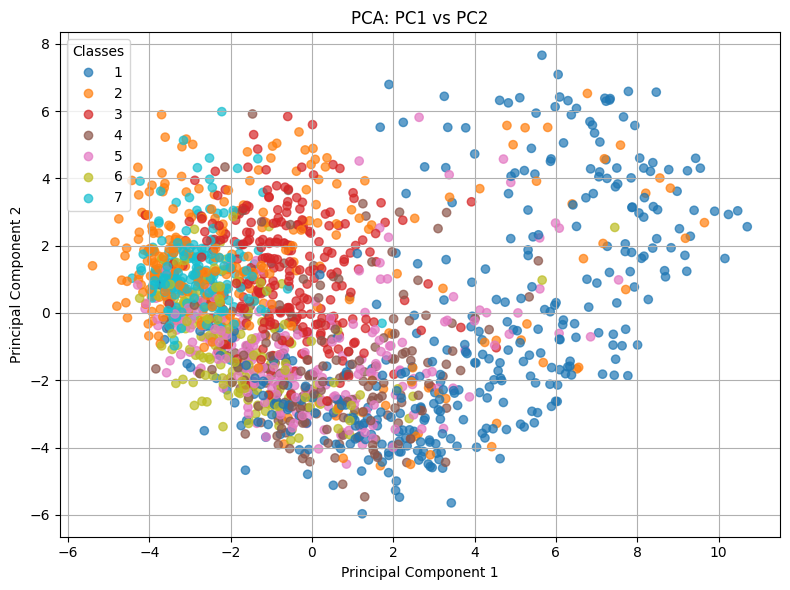

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Extract PC1 and PC2
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

# Plot PC1 vs PC2
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=y, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs PC2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.tight_layout()
plt.show()


In [4]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1715, 201)
y shape: (1715,)


In [91]:
models = {
    "KNN": (KNeighborsClassifier(), {
        'clf__n_neighbors': [i for i in range(1, 40, 4)],
        'clf__metric': ['minkowski', 'euclidean', 'manhattan']
    }),
    
    "LDA": (LinearDiscriminantAnalysis(), {
    }),
    
    "LogReg": (LogisticRegression(max_iter=1000), {
        'clf__C': [0.01, 0.1, 1, 10],
    }),
    
    "RandomForest": (RandomForestClassifier(), {
        'clf__n_estimators': [200, 300],
        'clf__max_depth': [20, 30],
    }),
    
    "SVM": (SVC(), {
        'clf__C': [0.1, 1, 10],
    }),
    
    "MLP": (MLPClassifier(max_iter=1000), {
        'clf__hidden_layer_sizes': [(50,), (100,),(150,)],
        'clf__alpha': [0.001, 0.01],
    })
}

In [108]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#how many train/test splits to run
repeats = 5

#declare variables to store important information: test acc, best params and confusion matrix values
test_accuracies = {name: [] for name in models.keys()}
best_params_across_runs = {name: [] for name in models.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int) for name in models.keys()}
run_metrics = {name: [] for name in models.keys()}
proba_outputs = {name: [] for name in models.keys()}
confidence_stats = {name: {'confident_ratio': [], 'confident_wrong_preds': []} for name in models.keys()}

#Outer loop for test/train splits
for i in range(repeats):
    print(f"\nRepetition {i+1}/{repeats}")
    
    #split data with stratified sampling into 20% test and 80% train
    all_indices = np.arange(len(X_scaled))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_scaled, y, all_indices, test_size=0.2, stratify=y)
    
    #Inner loop with 10-fold CV
    for name, (clf, param_grid) in models.items():

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])
        
        grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
        grid.fit(X_train, y_train)

        #compute metrics
        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        train_acc = accuracy_score(y_train, grid.predict(X_train))
        best_cv_score = grid.best_score_

        #store metrics
        test_accuracies[name].append(acc)
        best_params_across_runs[name].append(grid.best_params_)
        run_metrics[name].append({
            'train_acc': train_acc,
            'test_acc': acc,
            'cv_acc': best_cv_score,
            'best_params': grid.best_params_
        })

        #update confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix_sums[name] += cm

        #sensitivity and specificity
        sensitivities = []
        specificities = []
        for i in range(len(cm)):
            TP = cm[i, i]
            FN = cm[i, :].sum() - TP
            FP = cm[:, i].sum() - TP
            TN = cm.sum() - (TP + FN + FP)
            
            sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
            specificity = TN / (TN + FP) if TN + FP > 0 else 0

            sensitivities.append(sensitivity)
            specificities.append(specificity)

        avg_sensitivity = np.mean(sensitivities)
        avg_specificity = np.mean(specificities)

        # confidence analysis
        if hasattr(grid.best_estimator_['clf'], "predict_proba"):
            y_proba = grid.predict_proba(X_test)
            confidences = np.max(y_proba, axis=1)

            confident_mask = confidences>= 0.75
            confident_ratio = np.mean(confident_mask)

            high_conf_mask = confidences >= 0.85
            high_conf_wrong = ((y_pred != y_test) & high_conf_mask)

            num_strong_classes = np.sum(y_proba > 0.3, axis=1)
            ambiguous_mask = num_strong_classes >= 2

            #save probability and error data
            proba_outputs[name].append(y_proba)
            confidence_stats[name]['confident_ratio'].append(confident_ratio)
            confidence_stats[name]['confident_wrong_preds'].append(high_conf_wrong.sum())

            if 'confident_errors' not in confidence_stats[name]:
                confidence_stats[name]['confident_errors'] = []
            confidence_stats[name]['confident_errors'].append({
                'indices': idx_test[high_conf_wrong],
                'true_labels': y_test[high_conf_wrong],
                'pred_labels': y_pred[high_conf_wrong],
                'confidences': confidences[high_conf_wrong]
            })
            
            if 'ambiguous_predictions' not in confidence_stats[name]:
                confidence_stats[name]['ambiguous_predictions'] = []

            confidence_stats[name]['ambiguous_predictions'].append({
                'indices': idx_test[ambiguous_mask],
                'true_labels': y_test[ambiguous_mask],
                'pred_labels': y_pred[ambiguous_mask],
                'confidences': np.max(y_proba, axis=1)[ambiguous_mask],
                'num_strong_classes': num_strong_classes[ambiguous_mask],
                'full_proba': y_proba[ambiguous_mask]
            })

        else:
            print(f"{name} does not support predict_proba — skipping confidence analysis.")

        print(f"{name}: {acc:.4f}")


Repetition 1/5
KNN: 0.8309
LDA: 0.8484
LogReg: 0.8338
RandomForest: 0.8834
SVM does not support predict_proba — skipping confidence analysis.
SVM: 0.8688
MLP: 0.8309

Repetition 2/5
KNN: 0.8367
LDA: 0.8309
LogReg: 0.8484
RandomForest: 0.9067
SVM does not support predict_proba — skipping confidence analysis.
SVM: 0.8717
MLP: 0.8280

Repetition 3/5
KNN: 0.8163
LDA: 0.8105
LogReg: 0.8076
RandomForest: 0.8571
SVM does not support predict_proba — skipping confidence analysis.
SVM: 0.8484
MLP: 0.7901

Repetition 4/5
KNN: 0.8222
LDA: 0.7930
LogReg: 0.8105
RandomForest: 0.8571
SVM does not support predict_proba — skipping confidence analysis.
SVM: 0.8338
MLP: 0.7930

Repetition 5/5
KNN: 0.7988
LDA: 0.7988
LogReg: 0.8017
RandomForest: 0.8688
SVM does not support predict_proba — skipping confidence analysis.
SVM: 0.8222
MLP: 0.7988



KNN Best Parameters Across Runs:
  Run 1: {'clf__metric': 'manhattan', 'clf__n_neighbors': 33}
  Run 2: {'clf__metric': 'manhattan', 'clf__n_neighbors': 33}
  Run 3: {'clf__metric': 'manhattan', 'clf__n_neighbors': 13}
  Run 4: {'clf__metric': 'manhattan', 'clf__n_neighbors': 29}
  Run 5: {'clf__metric': 'manhattan', 'clf__n_neighbors': 37}

LDA Best Parameters Across Runs:
  Run 1: {}
  Run 2: {}
  Run 3: {}
  Run 4: {}
  Run 5: {}

LogReg Best Parameters Across Runs:
  Run 1: {'clf__C': 0.01}
  Run 2: {'clf__C': 0.01}
  Run 3: {'clf__C': 0.01}
  Run 4: {'clf__C': 0.01}
  Run 5: {'clf__C': 0.01}

RandomForest Best Parameters Across Runs:
  Run 1: {'clf__max_depth': 20, 'clf__n_estimators': 200}
  Run 2: {'clf__max_depth': 30, 'clf__n_estimators': 300}
  Run 3: {'clf__max_depth': 30, 'clf__n_estimators': 200}
  Run 4: {'clf__max_depth': 20, 'clf__n_estimators': 300}
  Run 5: {'clf__max_depth': 20, 'clf__n_estimators': 300}

SVM Best Parameters Across Runs:
  Run 1: {'clf__C': 10}
  Ru

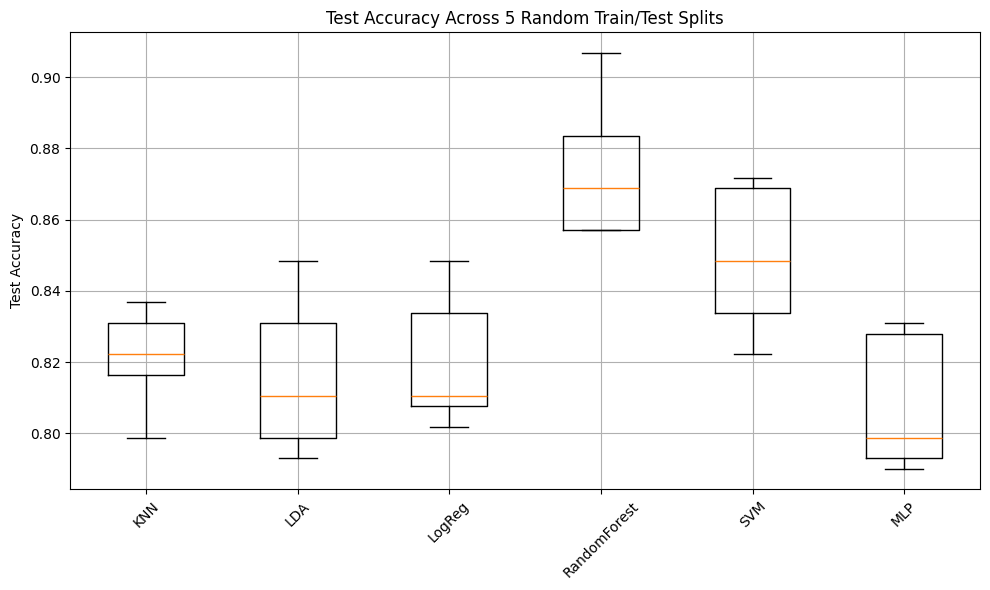

In [109]:
# Print best params for each model across all runs
for name, params_list in best_params_across_runs.items():
    print(f"\n{name} Best Parameters Across Runs:")
    for i, params in enumerate(params_list):
        print(f"  Run {i+1}: {params}")
        
plt.figure(figsize=(10, 6))
plt.boxplot([test_accuracies[name] for name in models.keys()], labels=models.keys())

plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Across 5 Random Train/Test Splits')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

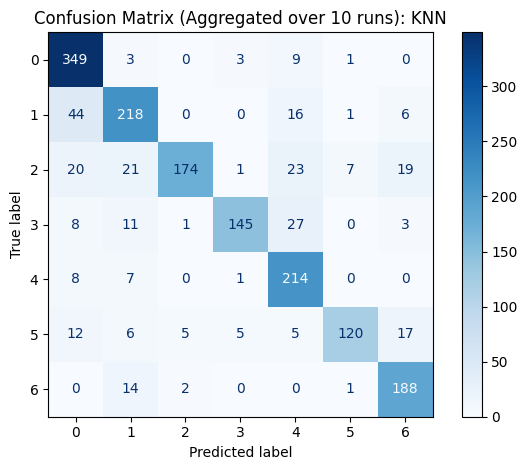

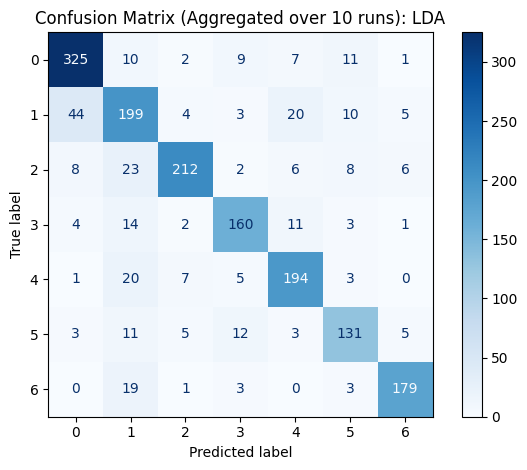

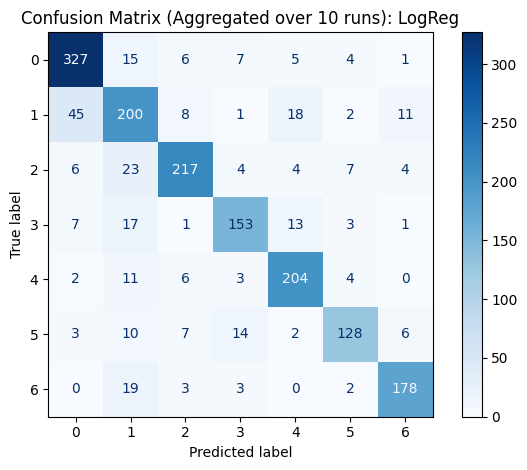

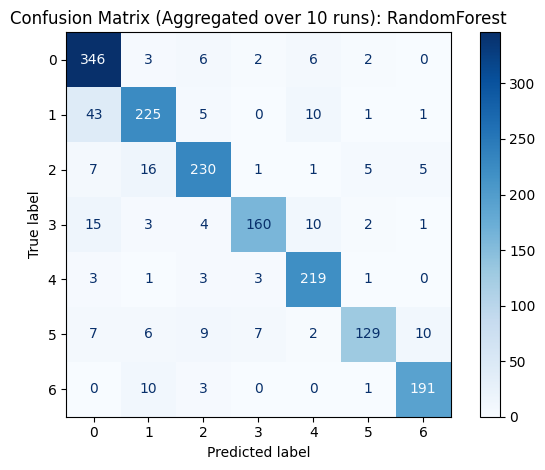

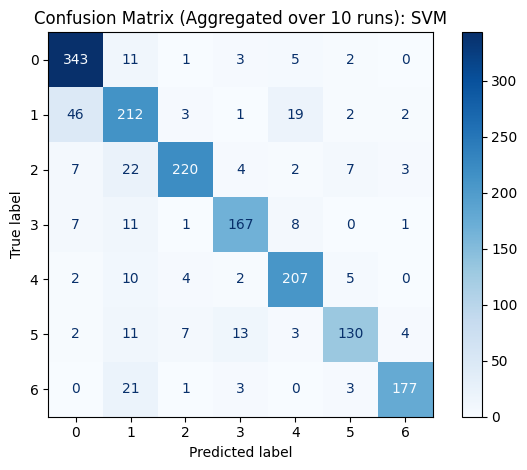

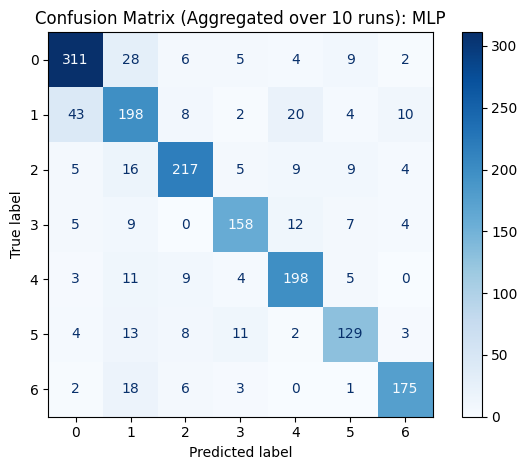

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for name, cm_sum in conf_matrix_sums.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix (Aggregated over 10 runs): {name}')
    plt.tight_layout()
    plt.show()

In [111]:
print("\n🔎 Confidence Summary (Thresholds: 0.8 and 0.9):")
for name in models:
    ratios = confidence_stats[name]['confident_ratio']
    wrongs = confidence_stats[name]['confident_wrong_preds']
    
    avg_ratio = np.mean(ratios)
    avg_wrong = np.mean(wrongs)
    
    print(f"{name}:")
    print(f"  Avg Confident Prediction Ratio (≥0.8): {avg_ratio:.2%}")
    print(f"  Avg High-Confidence Errors (≥0.9 & wrong): {avg_wrong:.1f} observations")



🔎 Confidence Summary (Thresholds: 0.8 and 0.9):
KNN:
  Avg Confident Prediction Ratio (≥0.8): 25.89%
  Avg High-Confidence Errors (≥0.9 & wrong): 1.8 observations
LDA:
  Avg Confident Prediction Ratio (≥0.8): 88.75%
  Avg High-Confidence Errors (≥0.9 & wrong): 33.0 observations
LogReg:
  Avg Confident Prediction Ratio (≥0.8): 43.09%
  Avg High-Confidence Errors (≥0.9 & wrong): 3.6 observations
RandomForest:
  Avg Confident Prediction Ratio (≥0.8): 13.53%
  Avg High-Confidence Errors (≥0.9 & wrong): 0.2 observations
SVM:
  Avg Confident Prediction Ratio (≥0.8): nan%
  Avg High-Confidence Errors (≥0.9 & wrong): nan observations
MLP:
  Avg Confident Prediction Ratio (≥0.8): 83.85%
  Avg High-Confidence Errors (≥0.9 & wrong): 26.2 observations


c:\Users\mlind\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mlind\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [112]:
from collections import defaultdict
import pandas as pd
import numpy as np

# Safely gather all high-confidence misclassifications across models and runs
confident_error_log = defaultdict(list)

for model_name in confidence_stats:
    for run_idx, err in enumerate(confidence_stats[model_name].get('confident_errors', [])):
        indices = np.array(err['indices'])
        true = np.array(err['true_labels'])
        pred = np.array(err['pred_labels'])
        confs = np.array(err['confidences'])

        # Loop through each misclassified observation in this run
        for idx_i, true_i, pred_i, conf_i in zip(indices, true, pred, confs):
            confident_error_log[idx_i].append({
                'model': model_name,
                'run': run_idx + 1,
                'true_class': true_i,
                'pred_class': pred_i,
                'confidence': round(conf_i, 3)
            })

# Now filter for observations misclassified by multiple models
multi_model_errors = {idx: entries for idx, entries in confident_error_log.items() if len(entries) > 1}

# Format into DataFrame
rows = []
for obs_idx, records in multi_model_errors.items():
    for r in records:
        rows.append({
            'Observation': obs_idx,
            'Model': r['model'],
            'Run': r['run'],
            'True Class': r['true_class'],
            'Predicted Class': r['pred_class'],
            'Confidence': r['confidence']
        })

df_errors = pd.DataFrame(rows)

# Sort for clarity
df_errors.sort_values(by=['True Class', 'Predicted Class', 'Observation'], inplace=True)



In [ ]:
print(confidence_stats["KNN"][""])

[0.239067055393586, 0.25072886297376096, 0.3556851311953353, 0.2565597667638484, 0.1924198250728863]


In [113]:
print(df_errors)


     Observation Model  Run  True Class  Predicted Class  Confidence
174          310   LDA    3           1                2       0.853
175          310   MLP    3           1                2       0.994
176          668   LDA    3           1                2       0.990
177          668   MLP    3           1                2       0.992
78           856   LDA    1           1                2       0.998
..           ...   ...  ...         ...              ...         ...
163          583   MLP    3           7                2       0.974
101          886   MLP    5           7                3       0.853
45           442   LDA    1           7                4       0.958
46           442   MLP    1           7                4       0.923
100          886   LDA    2           7                6       0.856

[248 rows x 6 columns]


In [114]:
# Count how many times each observation appears
obs_counts = df_errors['Observation'].value_counts()

# Filter to only those with more than 3 appearances
obs_to_keep = obs_counts[obs_counts > 3].index

# Apply the filter to the dataframe
df_errors_filtered = df_errors[df_errors['Observation'].isin(obs_to_keep)]

# Display the filtered result
print(df_errors_filtered)
print(df_errors_filtered["Observation"].unique())

     Observation Model  Run  True Class  Predicted Class  Confidence
139          834   LDA    2           1                4       0.960
140          834   LDA    3           1                4       0.974
141          834   MLP    2           1                4       0.973
142          834   MLP    3           1                4       0.987
121          158   LDA    2           2                1       0.989
..           ...   ...  ...         ...              ...         ...
120          426   MLP    5           5                4       0.995
53           165   LDA    1           7                2       0.868
54           165   LDA    2           7                2       0.940
55           165   MLP    1           7                2       0.874
56           165   MLP    2           7                2       0.912

[93 rows x 6 columns]
[ 834  158  492  654  803  831  849  881 1076 1081 1293 1430  381  720
  816  898 1305  426  165]


In [140]:
rows = []

for model_name in confidence_stats:
    for run_idx, run_data in enumerate(confidence_stats[model_name].get('ambiguous_predictions', [])):
        indices = np.array(run_data['indices'])
        true_labels = np.array(run_data['true_labels'])
        pred_labels = np.array(run_data['pred_labels'])
        confidences = np.array(run_data['confidences'])
        proba = np.array(run_data['full_proba'])

        for i in range(len(indices)):
            row = {
                'Run': run_idx + 1,
                'Model': model_name,
                'Observation': indices[i],
                'True Class': true_labels[i],
                'Predicted Class': pred_labels[i],
                'Confidence (Max)': round(confidences[i], 3)
            }

            for class_idx, class_prob in enumerate(proba[i]):
                row[f'Class_{class_idx}'] = round(class_prob, 3)

            rows.append(row)

df_ambiguous = pd.DataFrame(rows)
df_ambiguous.sort_values(by=['Observation', 'True Class','Model', 'Run'], inplace=True)



In [141]:
df_ambiguous


,Run,Model,Observation,True Class,Predicted Class,Confidence (Max),Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6
106,3,KNN,17,3,3,0.462,0.308,0.077,0.462,0.000,0.000,0.077,0.077
176,4,KNN,21,4,1,0.345,0.345,0.000,0.034,0.241,0.069,0.310,0.000
562,4,MLP,21,4,1,0.478,0.478,0.006,0.045,0.118,0.009,0.342,0.002
51,2,KNN,23,2,2,0.545,0.030,0.545,0.000,0.000,0.091,0.030,0.303
448,2,RandomForest,23,2,2,0.440,0.040,0.440,0.033,0.040,0.043,0.040,0.363
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,1,LogReg,1683,5,5,0.557,0.040,0.015,0.028,0.336,0.557,0.023,0.003
502,1,MLP,1683,5,5,0.634,0.000,0.000,0.000,0.365,0.634,0.000,0.000
323,1,LogReg,1686,3,2,0.397,0.139,0.397,0.024,0.031,0.380,0.005,0.024
24,1,KNN,1697,6,6,0.545,0.303,0.000,0.061,0.061,0.030,0.545,0.000


In [142]:

print(len(df_ambiguous["Observation"].unique()))

328


In [152]:
amb_obs_counts = df_ambiguous['Observation'].value_counts()

# Filter to only those with more than 3 appearances
amb_obs_to_keep = amb_obs_counts[amb_obs_counts > 4].index
df_amb_filtered = df_ambiguous[df_ambiguous['Observation'].isin(amb_obs_to_keep)]
print(df_amb_filtered.head(60))

#print(df_amb_filtered["Observation"].unique())


     Run         Model  Observation  True Class  Predicted Class  \
70     2           KNN          296           2                2   
217    5           KNN          296           2                2   
253    2           LDA          296           2                7   
348    2        LogReg          296           2                2   
383    3        LogReg          296           2                2   
514    2           MLP          296           2                2   
566    4           MLP          296           2                2   
164    3           KNN          297           4                4   
184    4           KNN          297           4                5   
568    4           MLP          297           4                4   
461    3  RandomForest          297           4                4   
471    4  RandomForest          297           4                4   
119    3           KNN          317           2                2   
207    5           KNN          317           2 

In [154]:
print(len(df_amb_filtered["Observation"].unique()))

15
